## Preprocessing

In [22]:
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter, sosfiltfilt, wiener

import matplotlib.pyplot as plt
import numpy as np

import librosa

import pandas as pd

import glob # fetching those damn files
import os # Making Folders/Directories
import csv # CSV for VAD
from tqdm import tqdm # Display Running Progress for whatever the reason there is

In [ ]:
INPUT_PATH = 'dataset/'
set_a_path = INPUT_PATH + 'set_a/'
set_b_path = INPUT_PATH + 'set_b/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def band_filter(x, samplerate, band_params):
  """
  Format:
  band = [lowcut, highcut, order]
  """
  lowcut, highcut, order = band_params

  # Bandpass Filter (sosfiltfilt applies the filter forward and backward, resulting in zero-phase filtering)
  nyq = 0.5 * samplerate
  low = max(lowcut / nyq, 1e-10)
  high = min(highcut / nyq, 0.999999)
  b = butter(order, [lowcut, highcut], btype='bandpass', fs=samplerate, output='sos')
  x = sosfiltfilt(b, x)

  return x

In [6]:
def rms(x, samplerate, frame_lenght, hop_length):
  frame_length = max(1, int(frame_lenght * samplerate))
  hop_length = max(1, int(hop_length * samplerate))

  rms_x = []
  for i in range(0, len(x) - frame_length + 1, hop_length):
    frame = x[i:i+frame_length]
    rms_val = np.sqrt(np.mean(frame**2))
    rms_x.append(rms_val)

  rms_x = np.array(rms_x, dtype=np.float32) # from list to back to float32
  time = np.arange(len(rms_x)) * hop_length / samplerate

  return rms_x, time

In [7]:
# ===== VAD (or Energy Detection) =====
def vad(x, samplerate, frame_length, hop_length, threshold):
  rms_x, time_rms = rms(x, samplerate, frame_length, hop_length)

  threshold = np.mean(rms_x) + 0.5 * np.std(rms_x) # adaptive thresholding (even though we already use normalization)
  #threshold = np.mean(x_out) + 0.2 * np.std(x_out) # exclude weird too loud beat
  # print("Mean : ", np.mean(rms_x))
  print("Threshold : ", threshold)

  active_frames = rms_x > threshold

  # === Collect Active Time ===
  active_times = []
  is_active = False
  for i, active in enumerate(active_frames):
    if active and not is_active:
      start = time_rms[i]
      is_active = True
    if not active and is_active:
      end = time_rms[i]
      active_times.append((start, end))
      is_active = False
  if is_active:
    active_times.append((start, time_rms[-1]))

  # Maybe removing the silent part before and after the first and last of the active times?

  return active_times, rms_x, time_rms

In [8]:
def data_frame(x, samplerate, max_dur):
  target_len = int(max_dur * samplerate)

  if len(x) >= target_len:
    x = x[:target_len]
  else: # uncomment one
    # == Zero Pad ==
    x = np.pad(x, (0, target_len - len(x)))

    # == Repeat ==
    # num_repeats = target_len // len(x)
    # remainder = target_len % len(x)
    # x = np.tile(x, num_repeats) # Repeat the signal fully
    # x = np.concatenate((x, x[:remainder])) # Add the remaining part

  return x

In [9]:
from scipy.signal import resample_poly

def resample_signal(x, in_fs, out_fs):
    # compute up/down factors
    from math import gcd
    g = gcd(in_fs, out_fs)

    up = out_fs // g
    down = in_fs // g

    return resample_poly(x, up, down)

In [10]:
# ===== Plot (for debugging) =====
def plot_sound(x, time, param=None):
  """
  param format: [title, xlable, ylabel]
  """
  plt.figure(figsize=(12, 3))
  plt.plot(time, x)
  plt.grid(True)
  if param not in [None, []]:
    plt.title(param[0])
    plt.xlabel(param[1])
    plt.ylabel(param[2])
  plt.show()

In [11]:
def plot_spectrogram(x, samplerate, param=None):
  # Compute STFT using scipy.signal
  # nperseg defines the length of each segment, commonly 256 or 512.
  # I'll use 512 as a reasonable default for audio.
  f, t, Zxx = signal.stft(x, fs=samplerate, nperseg=512)

  # Convert amplitude to dB. np.abs(Zxx) gives the amplitude spectrum.
  # Using 20 * log10 for amplitude. Add a small epsilon to avoid log(0).
  magnitude = np.abs(Zxx)
  amin = 1e-10 # Minimum amplitude for log calculation, equivalent to -100dB if ref=1
  Xdb = 20 * np.log10(np.maximum(amin, magnitude))

  # Plot using pcolormesh
  plt.figure(figsize=(12, 4))
  plt.pcolormesh(t, f, Xdb, shading='gouraud') # 'gouraud' or 'flat' for shading
  plt.colorbar(label='Amplitude (dB)')
  plt.ylabel('Frequency (Hz)')
  plt.xlabel('Time (s)')
  if param not in [None, []]:
    plt.title(param[0])
  plt.ylim([f.min(), f.max()]) # Ensure y-axis covers the full frequency range
  plt.show()


In [12]:
# ===== Main Preprocessing Function =====
def preprocess_signal(x, fs, params, do_debug = False):
  """
  Steps (recommended by the man himself):
  1) Input
  2) Normalize
  3) VAD
  4) Noise Reduction
  5) Output

  My doing (recommeded by the me myself):
  1) Input
  3) Resample (normalize frame, mostly to low sample rate)
  2) Noise Reduction
  4) Framing (normalize the duration, zero padding if less. Always zero padding after filtering)
  5) Normalize (normalize amplitude)
  6) Output
  """

  # === Pre-preprocess ===
  # Convert to mono
  if x.ndim > 1:
    x = x[:, 0]

  # Convert to float32
  x = x.astype(np.float32)

  # === Resampling ===
  fs_res = params['target_fs']
  x_res = resample_signal(x, fs, fs_res)

  # === Noise Reduction ===
  x_filt = band_filter(x_res, fs_res, [params['lowcut'], params['highcut'], params['order']])

  # === Data Frame ===
  x_framed = data_frame(x_filt, fs_res, params['maxdur'])

  # # === Downsampling ===
  # x_res = signal.decimate(x_framed, params['downfactor'])
  # fs_res= fs // params['downfactor']

  # === Normalize ===
  x_norm = x_framed / np.max(np.abs(x_framed))

  # === Debugging (only for 1 signal) ===
  if do_debug:
    time = np.arange(len(x)) / fs # Calculate time for original/pre-processed signals here
    time_res = np.arange(len(x_res)) / fs_res
    time_framed = np.arange(len(x_framed)) / fs_res
    # Plot
    plot_sound(x, time, ['Original Sound', 'time', 'amplitude'])
    plot_sound(x_res, time_res, ['Resampled', 'time', 'amplitude'])
    plot_sound(x_filt, time_res, ['Filtered', 'time', 'amplitude'])
    plot_sound(x_framed, time_framed, ['Framed', 'time', 'amplitude'])
    plot_sound(x_norm, time_framed, ['Normalized', 'time', 'amplitude'])

    plot_spectrogram(x, fs, ['Original', 'Frequency (Hz)', 'Time (s)'])
    plot_spectrogram(x_res, fs_res, ['Resampled', 'Frequency (Hz)', 'Time (s)'])
    plot_spectrogram(x_filt, fs_res, ['Filtered', 'Frequency (Hz)', 'Time (s)'])
    plot_spectrogram(x_norm, fs_res, ['Normalized', 'Frequency (Hz)', 'Time (s)'])

    print("Fs\t\t: ", fs)
    print("Frames\t: ", len(x))
    print("New Fs\t: ", fs_res)
    print("New Frames\t: ", len(x_framed))

    wavfile.write('/content/original_test.wav', fs, x.astype(np.int16))
    wavfile.write('/content/filter_test.wav', fs_res, x_filt.astype(np.int16))
    wavfile.write('/content/preprocessed_test.wav', fs_res, x_norm)

  # === Output ===
  return x_norm, fs_res

In [13]:
def preprocess_file(input_path, output_path, parameters, do_debug):
  samplerate, x = wavfile.read(input_path)
  x_out, fs_out = preprocess_signal(x, samplerate, parameters, do_debug)
  wavfile.write(output_path, fs_out, x_out)

In [14]:
def preprocess_folder(input_folder, output_folder, parameters):
  file_paths = glob.glob(os.path.join(input_folder, '*.wav'))

  # Progress (for dopamine and maybe debugging)
  for p in tqdm(file_paths, desc="Processing wav files"):
    try:
      preprocess_file(p, output_folder + os.path.basename(p), parameters, False)
    except Exception as e:
      print(f"Error processing {p}: {e}")

In [15]:
parameters = {
    #
    'maxdur': 5,
    'downfactor': 50,
    'target_fs' : 1000,

    # Bandpass Filter
    'lowcut': 50.0,
    'highcut': 450.0,
    'order': 4
}

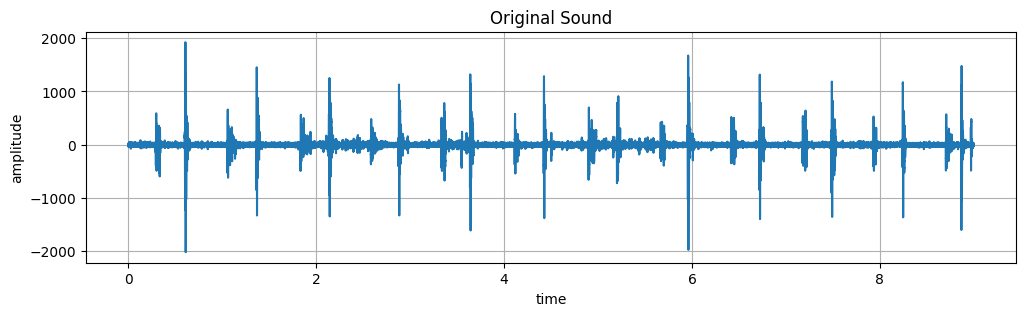

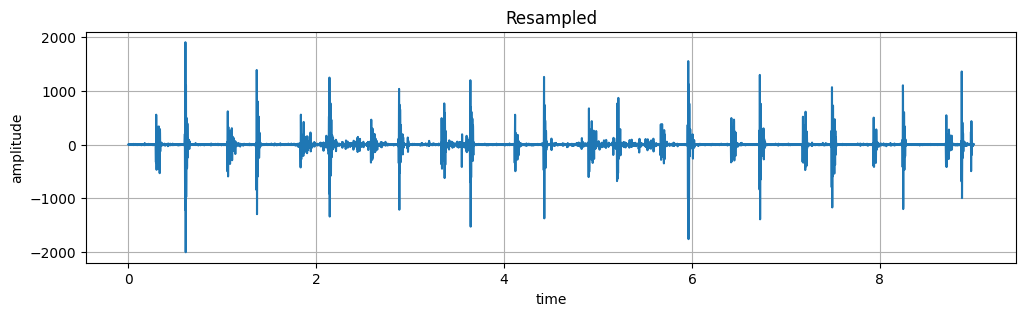

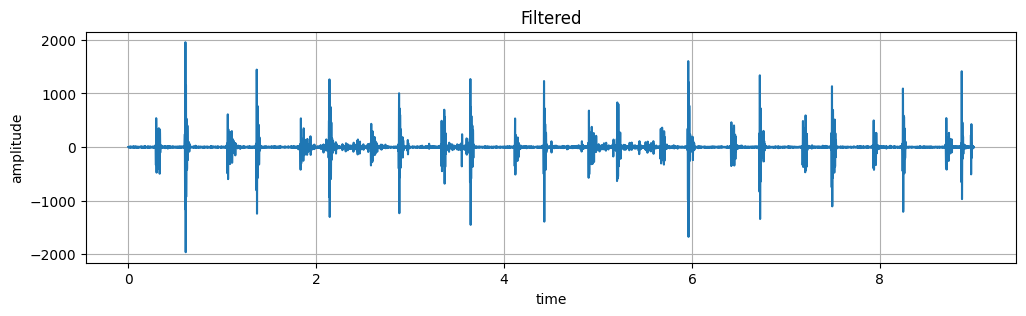

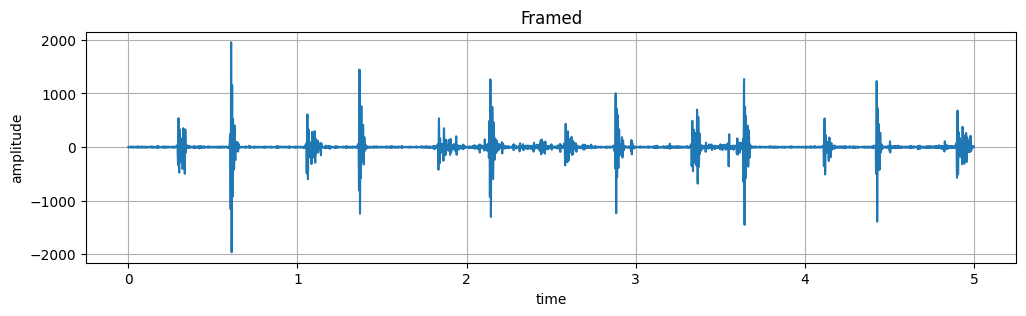

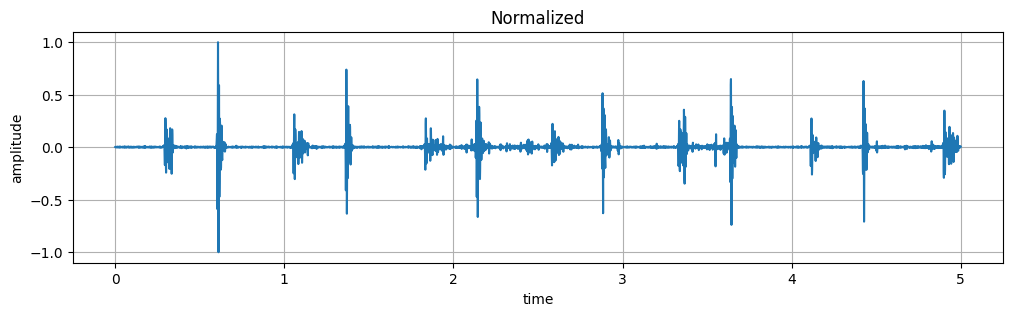

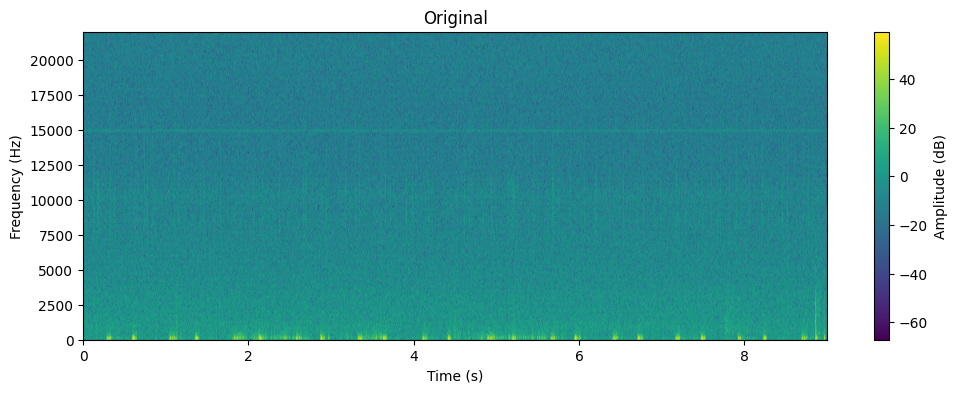

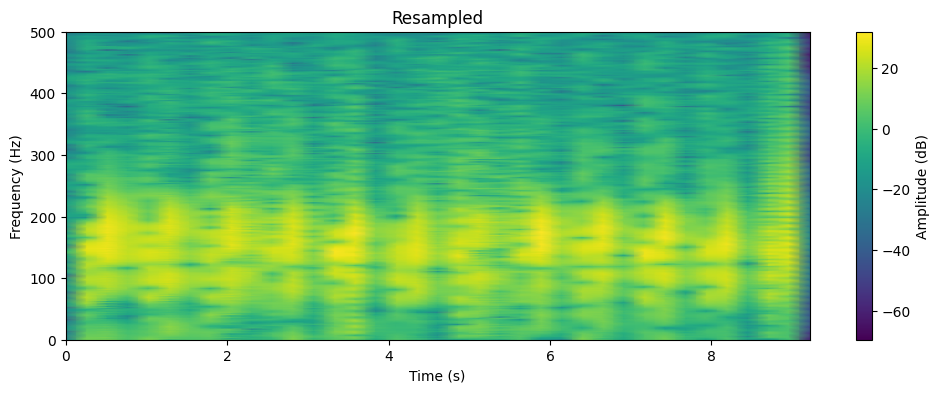

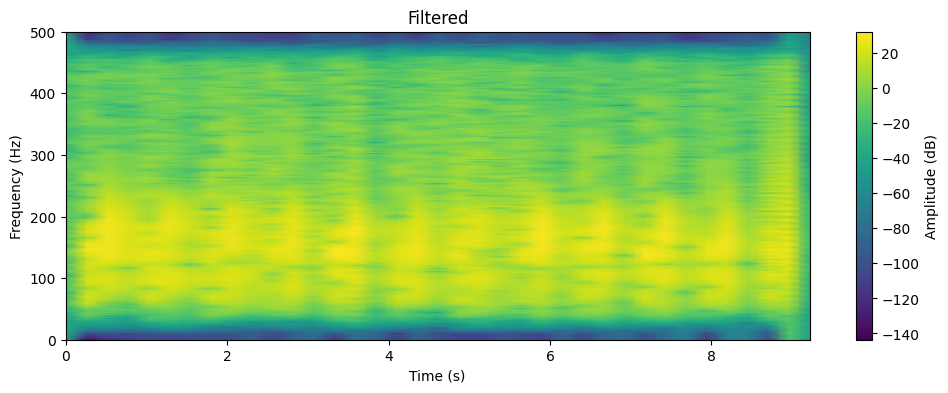

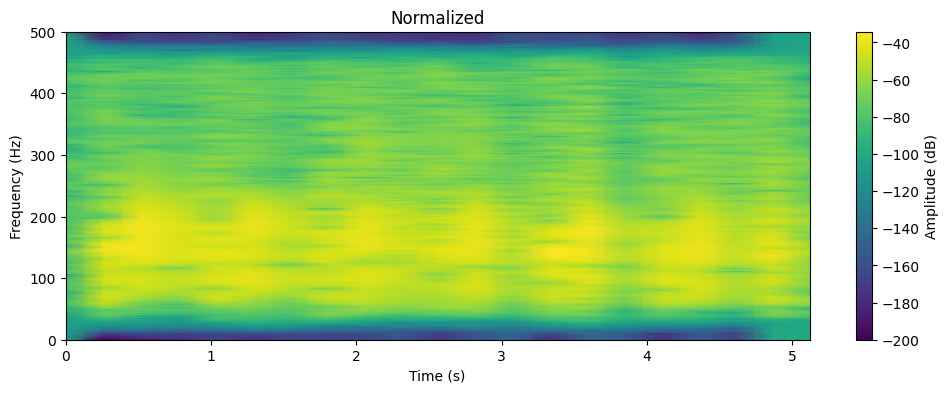

Fs		:  44100
Frames	:  396900
New Fs	:  1000
New Frames	:  5000


In [16]:
file_a1 = 'Aunlabelledtest__201012172010.wav'
file_a2 = 'Aunlabelledtest__201101051105.wav'
file_a3 = 'normal__201101070538.wav' # fast beat + thud sound that sound like heartbeat
file_a4 = 'normal__201102081321.wav' # high noise
file_a5 = 'normal__201101151127.wav' # 1 beat per cycle + noise + loud noise in middle
file_a6 = 'normal__201102201230.wav' # very low to no noise
file_a7 = 'normal__201102081152.wav' # 1 beat per cycle + ear breaking noise
file_a8 = 'murmur__201108222258.wav'
file_a9 = 'artifact__201106111119.wav'

file_b1 = 'extrastole__253_1309350256198_B.wav'
file_b2 = 'murmur_noisymurmur_272_1309370164386_C.wav'
file_b3 = 'normal__172_1307971284351_B1.wav'
file_b4 = 'extrastole__209_1308162216750_D.wav'

# == normal ==
input_file = INPUT_PATH + 'set_a/' + file_a6
# input_file = set_b_path + file_b3

# == murmur ==
# input_file = set_a_path + file_a8
# input_file = set_b_path + file_b3

output_folder = '/content/'
output_path = output_folder + os.path.basename(input_file)
os.makedirs(output_folder, exist_ok=True)

preprocess_file(input_file, output_path, parameters, True)

## Dataset Handling

In [17]:
"""
set_a.csv
set_a_timing.csv
set_b.csv
"""
set_a = pd.read_csv(INPUT_PATH + 'set_a.csv')
set_b = pd.read_csv(INPUT_PATH + 'set_b.csv')
display(set_a.head())
display(set_b.head())

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [18]:
set_com = pd.concat([set_a, set_b], ignore_index=True)
display(set_com)
display(set_com.describe())

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
827,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
828,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
829,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
830,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
freq,656,1,351,120


In [19]:
#get all unique labels
nb_classes=set_com.label.unique()

print("Number of training examples=", set_com.shape[0], "  Number of classes=", len(set_com.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


Min samples per category =  19
Max samples per category =  351


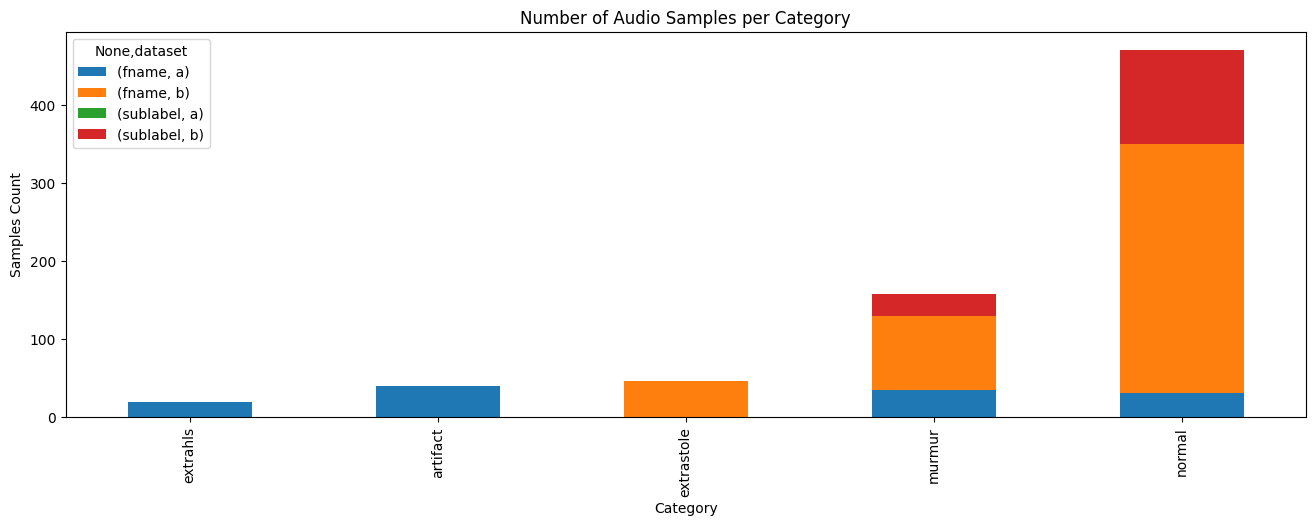

In [20]:
# visualize data distribution by category
category_group = set_com.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(set_com.label.value_counts()))
print('Max samples per category = ', max(set_com.label.value_counts()))

## Features Extraction

In [23]:
file_name = '/content/preprocessed_test.wav'
y, sr = librosa.load(file_name)


print(sr)

22050


/tmp/ipython-input-3790384237.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, x_axis='time', sr=sr)


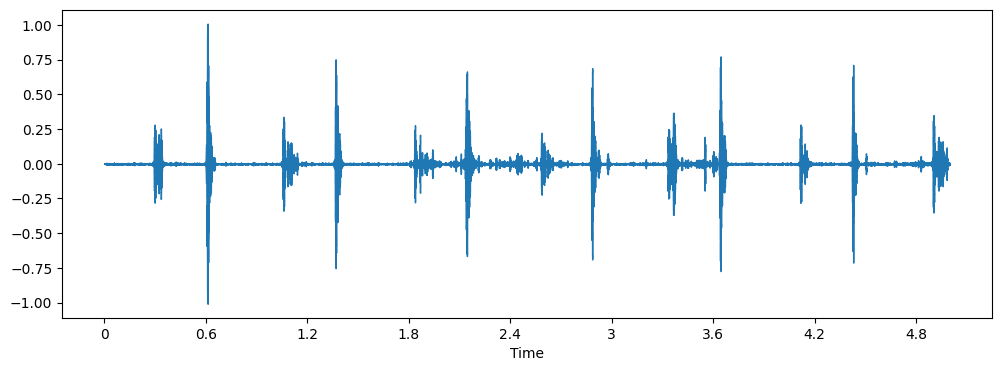

In [24]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, x_axis='time', sr=sr)

### Mel Frequency Cepstral Coefficients (MFCCs)

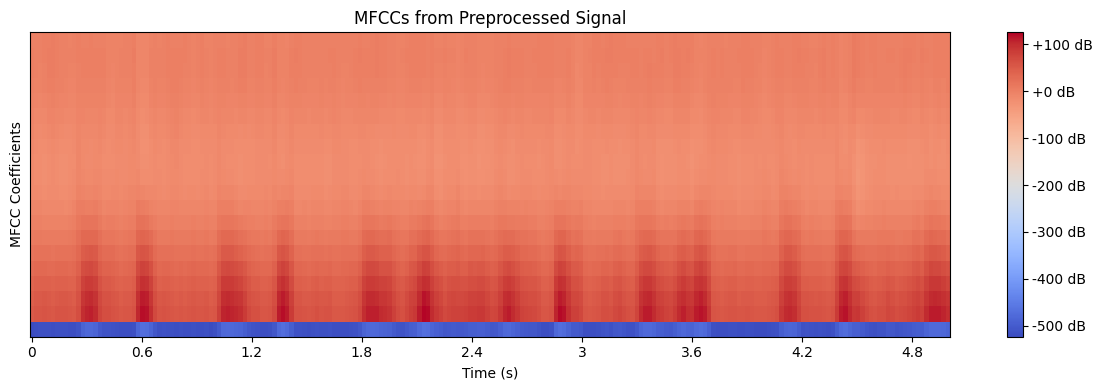

In [25]:
mfccs = librosa.feature.mfcc(y=y, sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs from Preprocessed Signal')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.tight_layout()
plt.show()

### Chroma

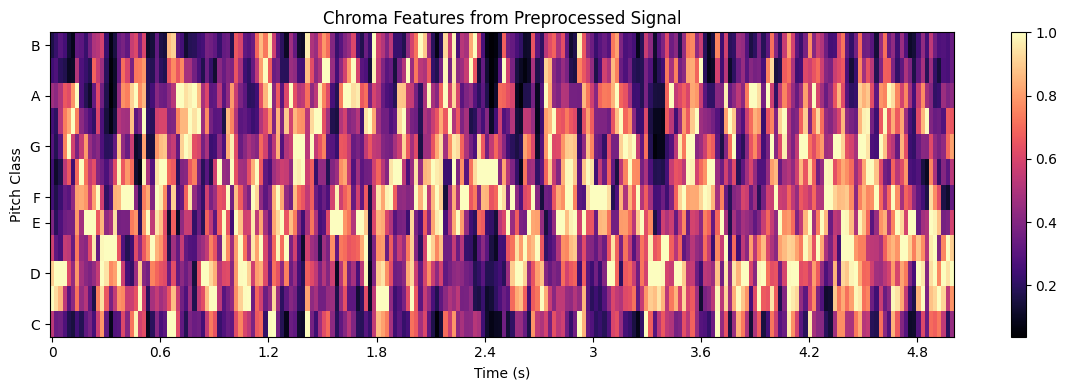

In [26]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Chroma Features from Preprocessed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.tight_layout()
plt.show()

### Mel Spectrogram

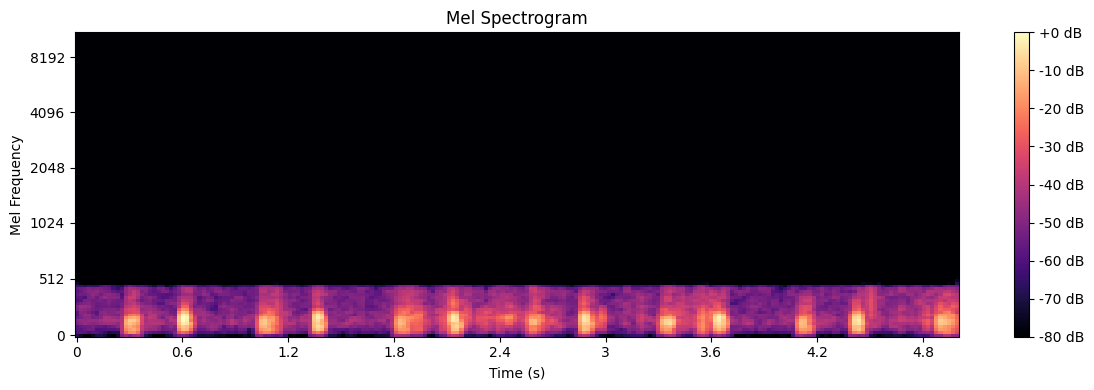

In [27]:
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

### Spectral Centroid

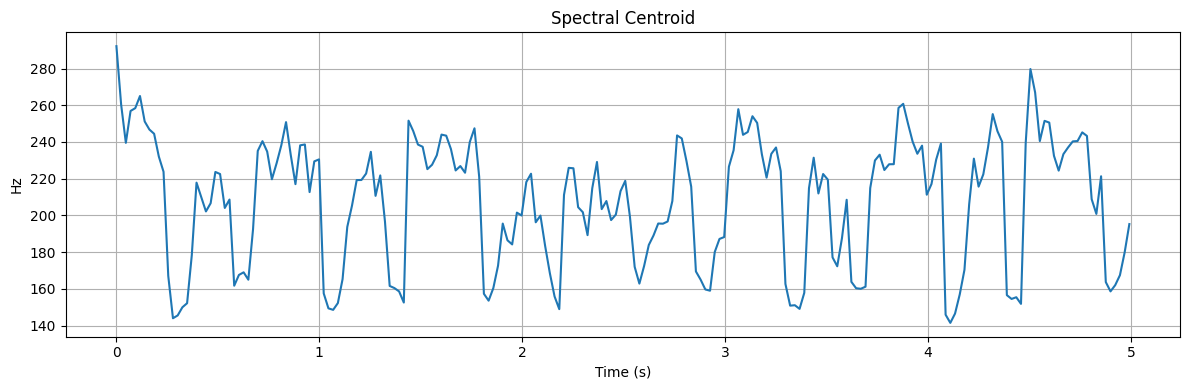

In [28]:
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(spectral_centroid, sr=sr), spectral_centroid.T)
plt.title('Spectral Centroid')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.grid(True)
plt.tight_layout()
plt.show()

### Spectral Bandwidth

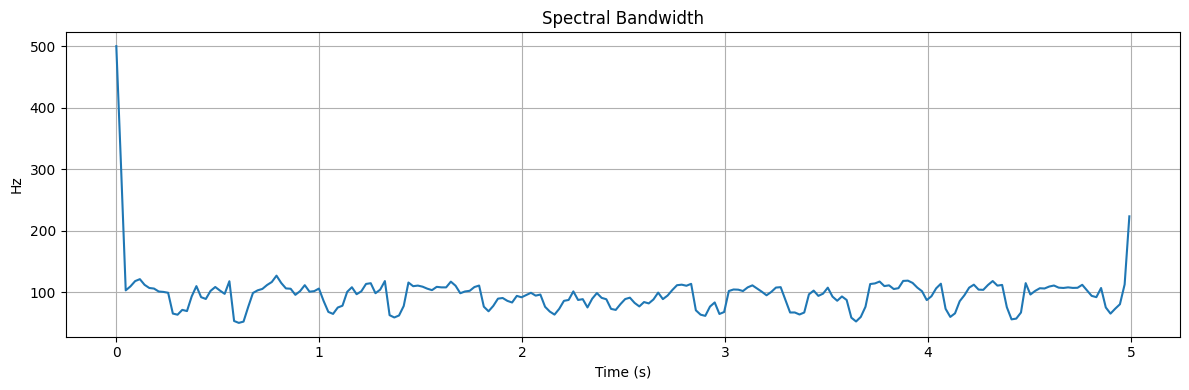

In [29]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(spectral_bandwidth, sr=sr), spectral_bandwidth.T)
plt.title('Spectral Bandwidth')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.grid(True)
plt.tight_layout()
plt.show()

### Spectral Rolloff

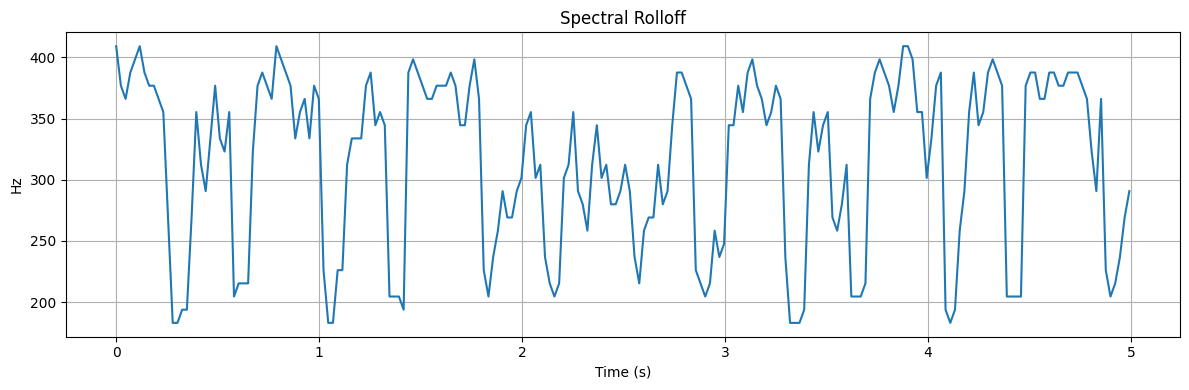

In [30]:
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(spectral_rolloff, sr=sr), spectral_rolloff.T)
plt.title('Spectral Rolloff')
plt.xlabel('Time (s)')
plt.ylabel('Hz')
plt.grid(True)
plt.tight_layout()
plt.show()

### Zero-Crossing Rate

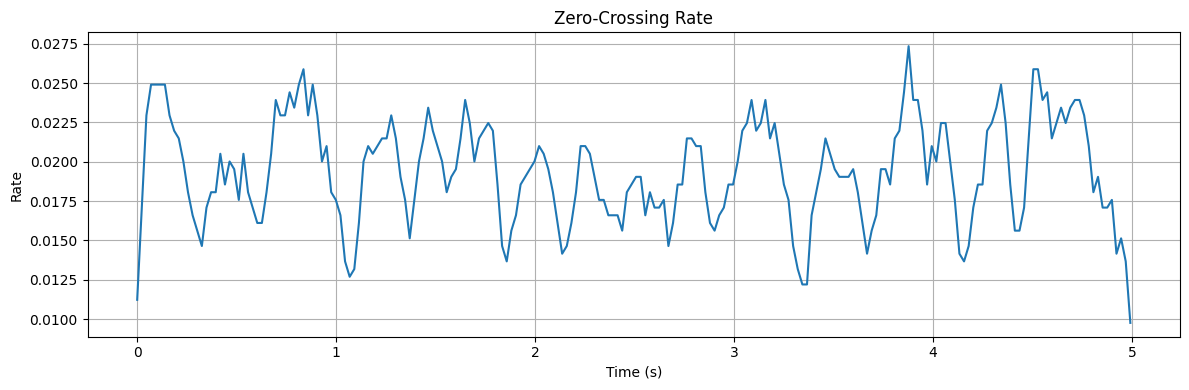

In [31]:
zcr = librosa.feature.zero_crossing_rate(y=y)

plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(zcr, sr=sr), zcr.T)
plt.title('Zero-Crossing Rate')
plt.xlabel('Time (s)')
plt.ylabel('Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

### Root Mean Square (RMS) Energy

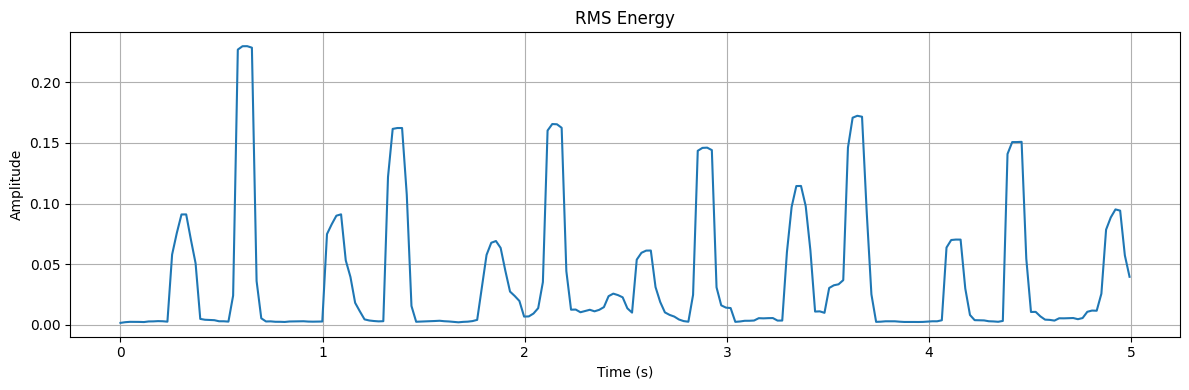

In [32]:
rms_energy = librosa.feature.rms(y=y)

plt.figure(figsize=(12, 4))
plt.plot(librosa.times_like(rms_energy, sr=sr), rms_energy.T)
plt.title('RMS Energy')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

### Onset

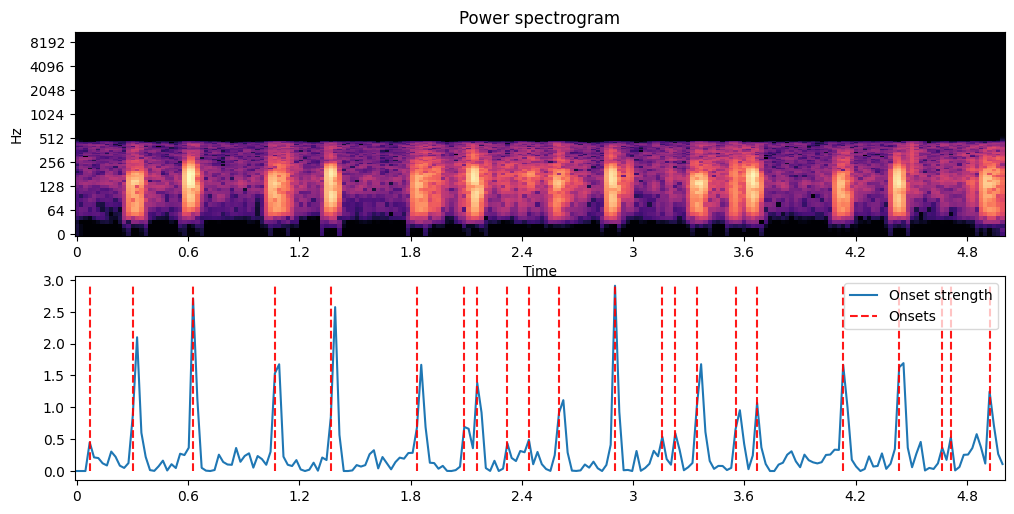

In [33]:
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)

o_env = librosa.onset.onset_strength(y=y, sr=sr) # Corrected line
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
plt.figure(figsize=(12, 9))

# ax1 = plt.subplot(3, 1, 1)
# librosa.display.waveshow(y, x_axis='time', sr=sr)
# plt.axis('tight')

ax1 = plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')

plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)

#### Onset Backtrack

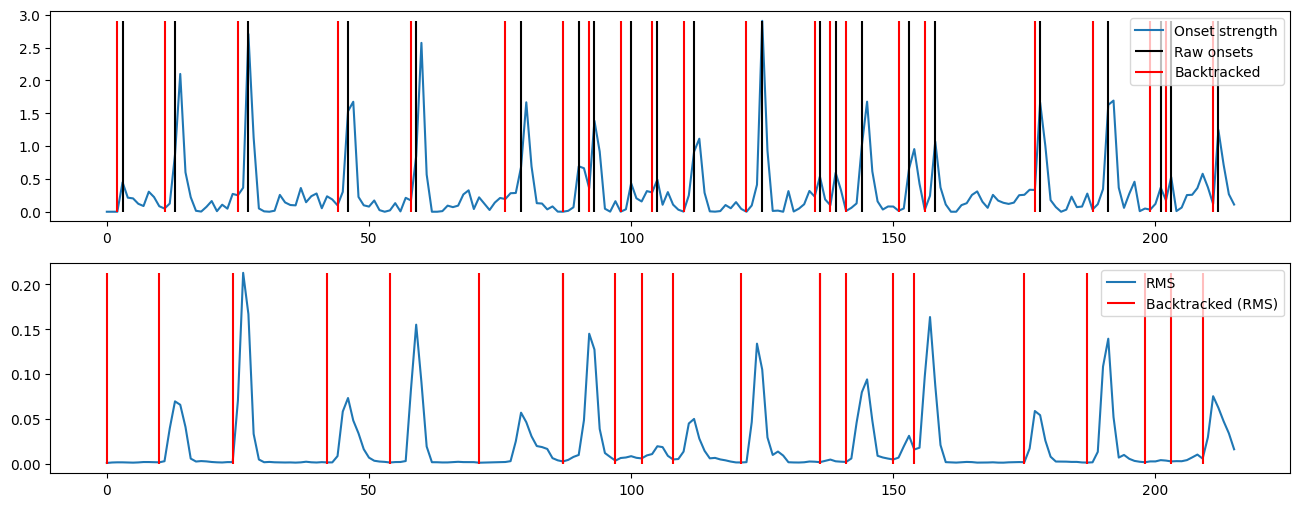

In [34]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets', color='black')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)

#### Onset Strength

Text(0.5, 1.0, 'Sub-band onset strength')

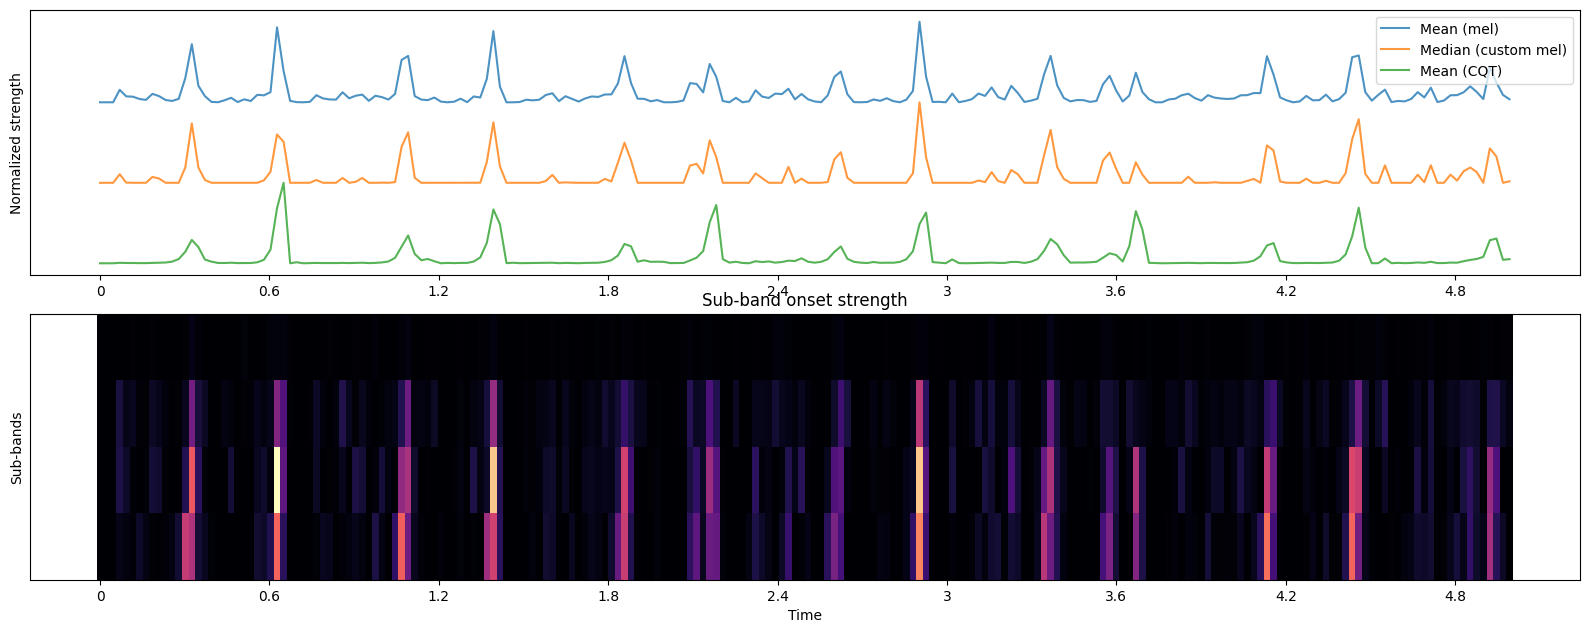

In [35]:
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))

plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,label='Mean (mel)')

# median
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median, fmax=500, n_mels=64)
plt.plot(times, 1 + onset_env / onset_env.max(), alpha=0.8,label='Median (custom mel)')

# Constant-Q spectrogram instead of Mel
C_cqt = np.abs(librosa.cqt(y=y, sr=sr))
onset_env_cqt = librosa.onset.onset_strength(S=C_cqt, sr=sr)
plt.plot(times, onset_env_cqt / onset_env_cqt.max(), alpha=0.8,label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 4, 8, 16, 32])
plt.subplot(2, 1, 2, sharex=ax1)
librosa.display.specshow(onset_subbands, x_axis='time', sr=sr)
plt.ylabel('Sub-bands')
plt.title('Sub-band onset strength')


## Classification

### Preparing Datasets

In [36]:
print("Number of training examples=", set_com.shape[0], "  Number of classes=", len(set_com.label.unique()))

Number of training examples= 832   Number of classes= 6


In [37]:
# set a
set_a_path = INPUT_PATH + 'set_a/'
a_artifact_files = glob.glob(os.path.join(set_a_path, 'artifact*.wav'))
a_normal_files = glob.glob(os.path.join(set_a_path, 'normal*.wav'))
a_murmur_files = glob.glob(os.path.join(set_a_path, 'murmur*.wav'))
a_extrahls_files = glob.glob(os.path.join(set_a_path, 'extrahls*.wav'))
a_test_files = glob.glob(os.path.join(set_a_path, 'Aunlabelledtest*.wav'))

print(a_artifact_files)

['/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201105061143.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201106040722.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201105040918.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201012172012.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201106021541.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201106010559.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201106040933.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201105041959.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201105051017.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201106010602.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__201105190800.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_a/artifact__2011060306

In [38]:
# set b
set_b_path = INPUT_PATH + 'set_b/'
b_normal_files = glob.glob(os.path.join(set_b_path, 'normal*.wav'))
b_murmur_files = glob.glob(os.path.join(set_b_path, 'murmur*.wav'))
b_extrastole_files = glob.glob(os.path.join(set_b_path, 'extrastole*.wav'))
b_test_files = glob.glob(os.path.join(set_b_path, 'Bunlabelledtest*.wav'))

print(b_normal_files)

['/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__168_1307970069434_A.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__250_1309202496494_B.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal_noisynormal_113_1306244002866_A.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal_noisynormal_133_1306759619127_B1.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal_noisynormal_101_1305030823364_B.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__238_1309194586293_B.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__129_1306344506305_D.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__179_1307990076841_D.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__177_1307989650056_B.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal__146_1306778707532_D2.wav', '/content/drive/MyDrive/Kuliah/SoundProc/dataset/set_b/normal_noisynormal_

In [39]:
a_artifact_fs = []
a_artifact_sounds = []
for i in a_artifact_files:
    fs, sound = wavfile.read(i)
    a_artifact_fs.append(fs)
    a_artifact_sounds.append(sound)

a_normal_fs = []
a_normal_sounds = []
for i in a_normal_files:
    fs, sound = wavfile.read(i)
    a_normal_fs.append(fs)
    a_normal_sounds.append(sound)

a_murmur_fs = []
a_murmur_sounds = []
for i in a_murmur_files:
    fs, sound = wavfile.read(i)
    a_murmur_fs.append(fs)
    a_murmur_sounds.append(sound)

a_extrahls_fs = []
a_extrahls_sounds = []
for i in a_extrahls_files:
    fs, sound = wavfile.read(i)
    a_extrahls_fs.append(fs)
    a_extrahls_sounds.append(sound)

b_normal_fs = []
b_normal_sounds = []
for i in b_normal_files:
    fs, sound = wavfile.read(i)
    b_normal_fs.append(fs)
    b_normal_sounds.append(sound)

b_murmur_fs = []
b_murmur_sounds = []
for i in b_murmur_files:
    fs, sound = wavfile.read(i)
    b_murmur_fs.append(fs)
    b_murmur_sounds.append(sound)

b_extrastole_fs = []
b_extrastole_sounds = []
for i in b_extrastole_files:
    fs, sound = wavfile.read(i)
    b_extrastole_fs.append(fs)
    b_extrastole_sounds.append(sound)

a_test_fs = []
a_test_sounds = []
for i in a_test_files:
    fs, sound = wavfile.read(i)
    a_test_fs.append(fs)
    a_test_sounds.append(sound)

b_test_fs = []
b_test_sounds = []
for i in b_test_files:
    fs, sound = wavfile.read(i)
    b_test_fs.append(fs)
    b_test_sounds.append(sound)


In [40]:
print(a_artifact_sounds)
print(a_artifact_fs)
print(a_normal_sounds)

[array([  -2,    2,   -2, ...,  114,  -27, -163], dtype=int16), array([ 19664,  22367,  24463, ..., -19325, -20104, -20444], dtype=int16), array([-2,  3, -4, ...,  0, -7, -6], dtype=int16), array([ 1, -3, -1, ...,  0,  1,  0], dtype=int16), array([  -1,    0,    1, ..., -100, -201, -144], dtype=int16), array([-49,   0,  17, ..., -63, -48, -57], dtype=int16), array([ -5,  -5,   2, ..., 445, 431, 425], dtype=int16), array([ 6, -4, -9, ...,  3,  2, -3], dtype=int16), array([ -85, -198, -214, ..., -110,  -74,  -76], dtype=int16), array([    52,  -1291,  -1116, ...,   -650, -11251, -13996], dtype=int16), array([  47,   70,   47, ..., -209, -346, -418], dtype=int16), array([ 97, 152, 167, ...,   0,  -2,   3], dtype=int16), array([-1390, -1358, -1372, ...,   -60,   -56,   -59], dtype=int16), array([605, 648, 473, ..., 499, 498, 459], dtype=int16), array([ 53, -35,  47, ..., -37, -71,  32], dtype=int16), array([ 71,  75,  73, ..., 244, 249, 232], dtype=int16), array([-2169, -2661, -1605, ..., 

In [41]:
# labeling

"""
label mapping:
==============
Artifact = 0
Normal = 1
Murmur = 2
Extrastole = 3
Extrahls = 4
Test = -1
"""

a_artifact_labels = [0] * len(a_artifact_sounds)
a_normal_labels = [1] * len(a_normal_sounds)
a_murmur_labels = [2] * len(a_murmur_sounds)
a_extrahls_labels = [4] * len(a_extrahls_sounds)
a_test_labels = [-1] * len(a_test_sounds)

b_normal_labels = [1] * len(b_normal_sounds)
b_murmur_labels = [2] * len(b_murmur_sounds)
b_extrastole_labels = [3] * len(b_extrastole_sounds)
b_test_labels = [-1] * len(b_test_sounds)

print(a_test_labels)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [42]:
# combine set a and set b
x_data = (a_artifact_sounds + a_normal_sounds + a_murmur_sounds + a_extrahls_sounds +
          b_normal_sounds + b_murmur_sounds + b_extrastole_sounds)
y_data = (a_artifact_labels + a_normal_labels + a_murmur_labels + a_extrahls_labels +
          b_normal_labels + b_murmur_labels + b_extrastole_labels)
fs_data = (a_artifact_fs + a_normal_fs + a_murmur_fs + a_extrahls_fs +
          b_normal_fs + b_murmur_fs + b_extrastole_fs)

test_x = (a_test_sounds + b_test_sounds)
test_y = (a_test_labels + b_test_labels)
test_fs = (a_test_fs + b_test_fs)

In [43]:
display(x_data[:10])
print(y_data)
print(fs_data)

[array([  -2,    2,   -2, ...,  114,  -27, -163], dtype=int16),
 array([ 19664,  22367,  24463, ..., -19325, -20104, -20444], dtype=int16),
 array([-2,  3, -4, ...,  0, -7, -6], dtype=int16),
 array([ 1, -3, -1, ...,  0,  1,  0], dtype=int16),
 array([  -1,    0,    1, ..., -100, -201, -144], dtype=int16),
 array([-49,   0,  17, ..., -63, -48, -57], dtype=int16),
 array([ -5,  -5,   2, ..., 445, 431, 425], dtype=int16),
 array([ 6, -4, -9, ...,  3,  2, -3], dtype=int16),
 array([ -85, -198, -214, ..., -110,  -74,  -76], dtype=int16),
 array([    52,  -1291,  -1116, ...,   -650, -11251, -13996], dtype=int16)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### Augmentation

In [44]:
import numpy as np
from scipy.signal import resample
from scipy.interpolate import interp1d
import random


# ---------------------------------------------------------
# AUGMENTATION FUNCTIONS
# ---------------------------------------------------------
def add_noise(signal, noise_factor=0.005):
  noise = np.random.randn(len(signal))
  return signal + noise_factor * noise


def random_gain(signal, gain_range=(0.8, 1.2)):
  gain = np.random.uniform(*gain_range)
  return signal * gain


def time_stretch(signal, stretch_factor=1.1):
  """Stretch/compress signal without pitch change."""
  n = len(signal)
  old_idx = np.arange(n)
  new_idx = np.linspace(0, n - 1, int(n / stretch_factor))
  interpolator = interp1d(old_idx, signal, fill_value="extrapolate")
  stretched = interpolator(new_idx)

  # Resample back to original length
  return resample(stretched, n)


def shift_signal(signal, max_shift=200):
  shift = np.random.randint(-max_shift, max_shift)
  return np.roll(signal, shift)


def dropout(signal, max_fraction=0.1):
  """Randomly zero out a portion of the signal."""
  s = signal.copy()
  length = len(signal)
  drop_len = int(length * max_fraction)
  start = np.random.randint(0, length - drop_len)
  s[start:start+drop_len] = 0
  return s


# List of augmentation options
AUGMENTATIONS = [
  add_noise,
  random_gain,
  time_stretch,
  shift_signal,
  dropout
]

In [45]:
def balance_dataset(signals, labels, samplerates, num_classes=None, max_count=None):
  """
  signals: list/array of 1D numpy arrays
  labels: list/array of integers [0..4]
  """
  # Combine data into tuples for easier handling
  data = [(sig, lab, sr) for sig, lab, sr in zip(signals, labels, samplerates)]

  # Count items per class
  if num_classes is None:
    num_classes = len(set(labels))

  class_counts = {c: sum(1 for _, lab, _ in data if lab == c) for c in range(num_classes)}

  if max_count is None or max_count < max(class_counts.values()):
    max_count = max(class_counts.values())


  print("Original class counts:", class_counts)
  print("Target per class:", max_count)

  # For each class, augment until balanced
  for c in range(num_classes):
    current_count = class_counts[c]
    need = max_count - current_count

    if need > 0:
      print(f"Augmenting class {c}: need {need} extra samples")

      # Get all (signal, samplerate) pairs of this class
      class_items = [(sig, sr) for sig, lab, sr in data if lab == c]

      # Generate new augmented samples
      for _ in range(need):
        base_sig, base_sr = random.choice(class_items) # Pick signal and its samplerate
        aug_func = random.choice(AUGMENTATIONS)
        new_sig = aug_func(base_sig)
        data.append((new_sig, c, base_sr)) # Add augmented signal, label, and its original samplerate

  # Separate the balanced data back into individual lists
  balanced_signals = [item[0] for item in data]
  balanced_labels = [item[1] for item in data]
  balanced_samplerates = [item[2] for item in data]

  print("Balanced dataset created.")
  return balanced_signals, balanced_labels, balanced_samplerates

In [46]:
# ---------------------------------------------------------
# USAGE EXAMPLE
# ---------------------------------------------------------

# Example:
# signals = [numpy_arrays...]
# labels = [0,1,1,3,2,4,...]

# balanced_signals, balanced_labels = balance_dataset(signals, labels)

balanced_data, balanced_labels, balanced_fs = balance_dataset(x_data, y_data, fs_data)

Original class counts: {0: 40, 1: 351, 2: 129, 3: 46, 4: 19}
Target per class: 351
Augmenting class 0: need 311 extra samples
Augmenting class 2: need 222 extra samples
Augmenting class 3: need 305 extra samples
Augmenting class 4: need 332 extra samples
Balanced dataset created.


In [47]:
print(balanced_labels)
print(balanced_fs)
print(len(balanced_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

#### Preprocess

In [48]:
label_map = {
    0: 'artifact',
    1: 'normal',
    2: 'murmur',
    3: 'extrastole',
    4: 'extrahls',
}

output_path = '/content/preprocessed_train/'
os.makedirs(output_path, exist_ok=True)

# List to store data for the CSV
csv_data = []

# Progress (for dopamine and maybe debugging)
for idx, x in tqdm(enumerate(balanced_data), total=len(balanced_data), desc="processing signals"):
  label = label_map[balanced_labels[idx]]
  output_name = label + '_' + str(idx) + '.wav'
  samplerate = balanced_fs[idx]
  try:
    x_out, fs_out = preprocess_signal(x, samplerate, parameters)
    wavfile.write(output_path + output_name, fs_out, x_out)
    # Collect data for CSV
    csv_data.append({'filename': output_name, 'label': label})
  except Exception as e:
    print(f"Error processing signal at index {idx}: {e}")

# Create DataFrame from collected data
df_labels = pd.DataFrame(csv_data)

# Save DataFrame to CSV
csv_output_path = '/content/preprocessed.csv'
df_labels.to_csv(csv_output_path, index=False)
print(f"Labels saved to {csv_output_path}")
display(df_labels.head())

processing signals: 100%|██████████| 1755/1755 [00:18<00:00, 95.08it/s]


Labels saved to /content/preprocessed.csv


,filename,label
0,artifact_0.wav,artifact
1,artifact_1.wav,artifact
2,artifact_2.wav,artifact
3,artifact_3.wav,artifact
4,artifact_4.wav,artifact


In [ ]:
#!zip -r preprocessed_train.zip preprocessed_train #im not going to redo this tomorrow

#### Splitting

In [49]:
import pandas as pd
import numpy as np
import os
# Removed librosa to avoid implicit data alteration
from sklearn.model_selection import train_test_split
from scipy.io import wavfile # Added wavfile for raw audio loading

# Load the CSV with preprocessed file information
df_preprocessed = pd.read_csv('/content/preprocessed.csv')

# Define the path to the preprocessed audio files
preprocessed_audio_path = '/content/preprocessed_train/'

# Get the target sample rate from the parameters used during preprocessing
target_sample_rate = parameters['target_fs']

# Lists to store features (audio data) and labels
X = []
y = []

for index, row in df_preprocessed.iterrows():
    file_path = os.path.join(preprocessed_audio_path, row['filename'])
    # Load the audio file using wavfile.read, which does not alter the data
    sr_read, audio = wavfile.read(file_path)

    # Ensure the sample rate matches the target sample rate after preprocessing
    if sr_read != target_sample_rate:
        print(f"Warning: Sample rate mismatch for {row['filename']}. Expected {target_sample_rate}, got {sr_read}.")
        # Depending on requirements, you might want to resample here or skip the file.
        # Given previous preprocessing should ensure this, it indicates an issue if it doesn't match.
        raise ValueError(f"Sample rate mismatch for {row['filename']}.")

    # Ensure audio data is float32 for consistency with librosa's default output and further processing
    if audio.dtype != np.float32:
        audio = audio.astype(np.float32)

    X.append(audio)
    y.append(row['label'])

# Convert labels to numerical format if not already (assuming label_map exists)
label_to_int = {'artifact': 0, 'normal': 1, 'murmur': 2, 'extrastole': 3, 'extrahls': 4}
y_numeric = np.array([label_to_int[label] for label in y])

# All audio files are already of the same length due to preprocessing (data_frame function)
X_final = np.array(X)

# Split the dataset into training and testing sets
# Using a 80/20 split and a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_final, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric)


In [50]:
# Display the shapes of the resulting datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (1404, 5000)
Shape of X_test: (351, 5000)
Shape of y_train: (1404,)
Shape of y_test: (351,)


In [51]:
print(X_train[:5])

[[ 1.2311902e-03  1.4335301e-02 -8.0981040e-03 ...  1.6266977e-02
   5.5636577e-02  1.6272123e-01]
 [-3.6235640e-04 -2.6097024e-02 -2.5617046e-02 ... -7.3236816e-02
   4.8884440e-02  6.7844056e-02]
 [ 7.9528916e-05  4.9377368e-03  6.6788010e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 9.7437751e-06 -1.9537023e-05 -5.6440902e-05 ...  1.2296617e-04
   1.1576822e-04  1.3353721e-04]
 [-1.2505036e-04  2.8404774e-02  3.1621139e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


### Extract Feature

#### MFCCs

In [52]:
!pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=8cbc87911c4cecb43aa42be06757f67f4634ecd591de450df09a01478c4d030d
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


In [53]:
import numpy as np
from scipy import signal
# from scipy.fft import dct # Not directly needed if using python_speech_features.mfcc
from python_speech_features import mfcc # New import

def extract_features(signal, sr, n_mfcc=13, n_fft=256, hop_length=64, n_mels=40, max_pad_len=500):
    # Ensure the signal is float32
    signal = signal.astype(np.float32)

    # Calculate winlen and winstep for python_speech_features (in seconds)
    winlen = n_fft / sr
    winstep = hop_length / sr

    # Extract MFCCs using python_speech_features
    # numcep: Number of cepstra to return (including 0th)
    # nfilt: Number of filters in the filterbank
    mfccs = mfcc(signal,
                 samplerate=sr,
                 winlen=winlen,
                 winstep=winstep,
                 numcep=n_mfcc,
                 nfilt=n_mels,
                 nfft=n_fft,
                 lowfreq=0,
                 highfreq=sr/2,
                 preemph=0.97,
                 ceplifter=22,
                 appendEnergy=True
                )

    # python_speech_features returns (num_frames, num_cepstra).
    # Transpose to get (num_cepstra, num_frames) for consistency with previous librosa-like output
    mfccs = mfccs.T

    # Pad/Truncate MFCCs to a fixed length (time_frames dimension)
    if mfccs.shape[1] < max_pad_len:
        # Pad with zeros if shorter
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate if longer
        mfccs = mfccs[:, :max_pad_len]

    return mfccs

In [54]:
# Get target sample rate from parameters
sr = parameters['target_fs']

# Extract MFCCs for training data
X_train_mfccs = []
for audio_signal in tqdm(X_train, desc="Extracting MFCCs for X_train"):
    mfccs = extract_features(audio_signal, sr)
    X_train_mfccs.append(mfccs)
X_train_mfccs = np.array(X_train_mfccs)

# Extract MFCCs for testing data
X_test_mfccs = []
for audio_signal in tqdm(X_test, desc="Extracting MFCCs for X_test"):
    mfccs = extract_features(audio_signal, sr)
    X_test_mfccs.append(mfccs)
X_test_mfccs = np.array(X_test_mfccs)

print(f"Shape of X_train_mfccs: {X_train_mfccs.shape}")
print(f"Shape of X_test_mfccs: {X_test_mfccs.shape}")

Extracting MFCCs for X_test: 100%|██████████| 351/351 [00:00<00:00, 390.99it/s]

Shape of X_train_mfccs: (1404, 13, 500)
Shape of X_test_mfccs: (351, 13, 500)


In [ ]:
display(X_train_mfccs[0])

array([[ -3.92453323,  -3.75170012,  -3.72044703, ...,   0.        ,
          0.        ,   0.        ],
       [-13.153353  , -16.72611675,  -8.05543121, ...,   0.        ,
          0.        ,   0.        ],
       [-46.74561114, -40.50361619, -39.42099771, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-23.22407705,  -1.79329181, -17.18441928, ...,   0.        ,
          0.        ,   0.        ],
       [ 21.6380807 ,  18.03509711,  31.9390938 , ...,   0.        ,
          0.        ,   0.        ],
       [ -7.03876672,   5.71751108, -13.01293301, ...,   0.        ,
          0.        ,   0.        ]])

### Machine Learning Model

#### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Reshape MFCCs for the classifier
# Current shape: (n_samples, n_mfcc, n_time_frames)
# Desired shape: (n_samples, n_mfcc * n_time_frames)

n_samples_train, n_mfcc, n_time_frames = X_train_mfccs.shape
X_train_reshaped = X_train_mfccs.reshape(n_samples_train, n_mfcc * n_time_frames)

n_samples_test = X_test_mfccs.shape[0]
X_test_reshaped = X_test_mfccs.reshape(n_samples_test, n_mfcc * n_time_frames)

print(f"Reshaped X_train_mfccs shape: {X_train_reshaped.shape}")
print(f"Reshaped X_test_mfccs shape: {X_test_reshaped.shape}")

Reshaped X_train_mfccs shape: (1404, 6500)
Reshaped X_test_mfccs shape: (351, 6500)


In [56]:
# Initialize and train the Random Forest Classifier
# Using a reasonable number of estimators and a fixed random_state for reproducibility
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

print("Training Random Forest Classifier...")
rf_classifier.fit(X_train_reshaped, y_train)
print("Training complete.")

Training Random Forest Classifier...
Training complete.


In [57]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_to_int.keys())

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.9544

Classification Report:
              precision    recall  f1-score   support

    artifact       1.00      0.99      0.99        70
      normal       0.88      0.91      0.90        70
      murmur       0.93      0.90      0.91        70
  extrastole       0.99      0.97      0.98        71
    extrahls       0.99      1.00      0.99        70

    accuracy                           0.95       351
   macro avg       0.95      0.95      0.95       351
weighted avg       0.96      0.95      0.95       351



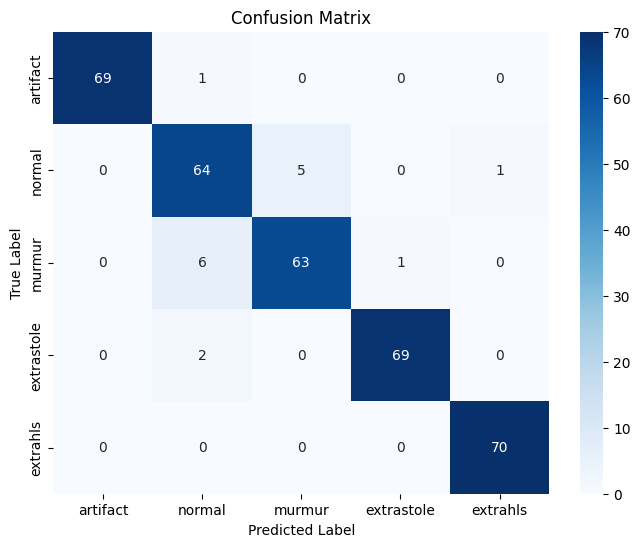

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_int.keys(), yticklabels=label_to_int.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVM

In [59]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the Support Vector Machine Classifier
# Using a linear kernel for potentially faster training with high-dimensional data,
# but you can experiment with 'rbf' or others. C is the regularization parameter.
svm_classifier = SVC(kernel='linear', random_state=42) # You might consider 'rbf' for non-linear decision boundaries

print("Training SVM Classifier...")
svm_classifier.fit(X_train_reshaped, y_train)
print("Training complete.")

Training SVM Classifier...
Training complete.


SVM Accuracy: 0.9088

SVM Classification Report:
              precision    recall  f1-score   support

    artifact       0.97      1.00      0.99        70
      normal       0.87      0.69      0.77        70
      murmur       0.83      0.91      0.87        70
  extrastole       0.88      0.97      0.93        71
    extrahls       0.99      0.97      0.98        70

    accuracy                           0.91       351
   macro avg       0.91      0.91      0.91       351
weighted avg       0.91      0.91      0.91       351



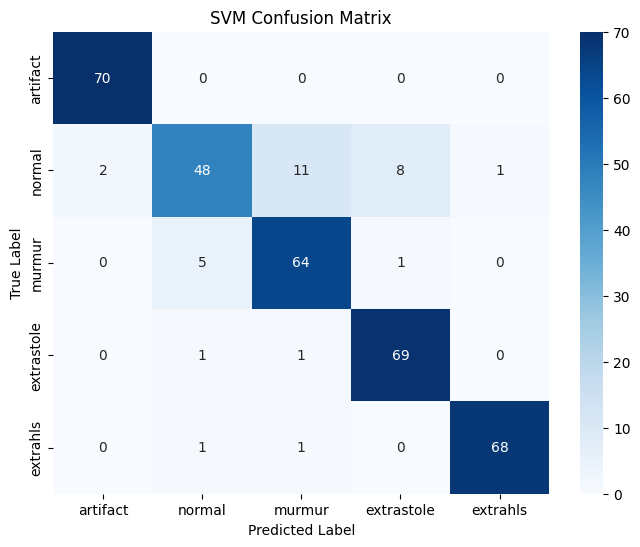

In [60]:
# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test_reshaped)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, target_names=label_to_int.keys())

print(f"SVM Accuracy: {accuracy_svm:.4f}")
print("\nSVM Classification Report:")
print(report_svm)

# Generate and plot the confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_int.keys(), yticklabels=label_to_int.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

#### CNN

In [61]:
X_train_cnn = np.expand_dims(X_train_mfccs, axis=-1)
X_test_cnn = np.expand_dims(X_test_mfccs, axis=-1)

print(f"Shape of X_train_cnn: {X_train_cnn.shape}")
print(f"Shape of X_test_cnn: {X_test_cnn.shape}")

Shape of X_train_cnn: (1404, 13, 500, 1)
Shape of X_test_cnn: (351, 13, 500, 1)


In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train_cnn.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_to_int), activation='softmax') # Output layer with number of classes and softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 498, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 249, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 247, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 123, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,007,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,205 (3.92 MB)

 Trainable params: 1,027,205 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
epochs = 50
batch_size = 32

print("Training CNN model...")
history = model.fit(X_train_cnn, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_cnn, y_test))
print("CNN model training complete.")

Training CNN model...
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.3981 - loss: 2.2106 - val_accuracy: 0.7094 - val_loss: 0.8123
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.6483 - loss: 0.8391 - val_accuracy: 0.7123 - val_loss: 0.6668
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7060 - loss: 0.7107 - val_accuracy: 0.6980 - val_loss: 0.6414
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.7184 - loss: 0.6148 - val_accuracy: 0.8120 - val_loss: 0.5529
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.7642 - loss: 0.5666 - val_accuracy: 0.8234 - val_loss: 0.4968
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7875 - loss: 0.5245 - val_accuracy: 0.8205 - val_loss: 0.4510
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.8268 - loss: 0.4285 - val_accuracy: 0.8348 - val_loss: 0.4147
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.8746 - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
CNN Accuracy: 0.9259

CNN Classification Report:
              precision    recall  f1-score   support

    artifact       1.00      0.99      0.99        70
      normal       0.92      0.70      0.80        70
      murmur       0.80      0.96      0.87        70
  extrastole       0.93      0.99      0.96        71
    extrahls       1.00      1.00      1.00        70

    accuracy                           0.93       351
   macro avg       0.93      0.93      0.92       351
weighted avg       0.93      0.93      0.92       351



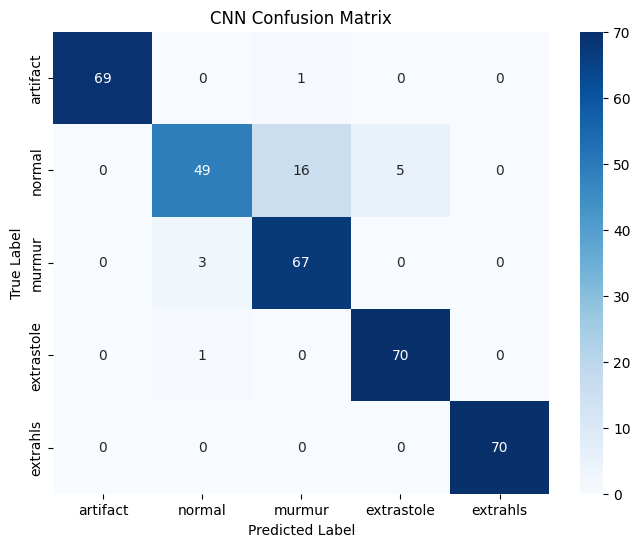

In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Use the trained model to make predictions on the X_test_cnn data
y_pred_proba_cnn = model.predict(X_test_cnn)

# 2. Convert the predicted probabilities to class labels
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

# 3. Calculate the overall accuracy of the CNN model
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"CNN Accuracy: {accuracy_cnn:.4f}")

# 4. Generate a classification report
report_cnn = classification_report(y_test, y_pred_cnn, target_names=label_to_int.keys())
print("\nCNN Classification Report:")
print(report_cnn)

# 5. Compute the confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# 6. Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_int.keys(), yticklabels=label_to_int.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()